In [10]:
# imports
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
import time

from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [11]:
# -- ARCHIVED --
# upload / download models and logs to tensorboard

# copy relevant model metrics into seperate folder and upload to tensorboard dev
# data_filter = 'test' # 'train', 'test' or 'validation'
# model_filter = 'resnet'# 'basic' or 'resnet'
# log_path = '../logs/scalars'
# upload_path = '../tensorboard_upload/'
# os.mkdir(upload_path)

# for (dirpath, dirnames, filenames) in os.walk(log_path):
#     # filter dirs
#     if data_filter in dirpath and model_filter in dirpath:

#         from_directory = dirpath
#         to_directory = upload_path + dirpath[16:]

#         # copy dir trees
#         shutil.copytree(from_directory, to_directory)

# # TODO: run in project root for upload
# print(f'tensorboard dev upload --logdir=./tensorboard_upload/ --name FLE_{model_filter}_{data_filter}')

# # remove copied dir trees
# shutil.rmtree(upload_path)

# # TODO: set tensorboard dev ID
# experiment_ids = ['0m4NvD5jTxmSw3hr8SeJww', 'uLYWP18zQ1eMtDBiLHLHrg'] # [resnet, basic]
# all_dfs = []

# # download experiments
# for ind, id in enumerate(experiment_ids):
#     experiment = tb.data.experimental.ExperimentFromDev(id)
#     df_temp = experiment.get_scalars()
    
#     print(f'{ind}: {df_temp.shape}')
#     all_dfs.append(df_temp)

# # combine experiments into single dataframe
# df = all_dfs[0]

# if len(all_dfs) > 1:
#     for new_df in all_dfs[1:]:
#         df = pd.concat([df, new_df])

# print(df.shape)
# df.head()

In [12]:
log_path = '../logs/class_report'
filter = 'class_report_19epoch.json'
logs = [['accuracy']
        , ['macro avg', 'precision']
        , ['macro avg', 'recall']
        , ['macro avg', 'f1-score']
        , ['weighted avg', 'precision']
        , ['weighted avg', 'recall']
        , ['weighted avg', 'f1-score']
]

In [13]:
df_headers = ['run', 'model', 'ratio', 'classes', 'epoch', 'metric', 'value']

df = pd.DataFrame(columns=df_headers)

counter = 0
for (dirpath, dirnames, filenames) in os.walk(log_path):

    if filter in filenames:
        counter += 1

        file_path = dirpath+'/'+filter
        class_report = json.load(open(file_path))

        for log in logs:

            run = dirpath.split('\\', 1)[-1].replace('\\', '_')
            model = re.search('(^[a-z]{5,6})_', run).group(1)
            ratio = float(re.search('(\d{5})r', run).group(1)) / 100
            classes = re.search('(\d{1,2})c', run).group(1)
            epoch = re.search('(\d{2})epoch', file_path).group(1)
            
            if len(log) == 1:
                metric = log[0]
                value = class_report[log[0]]
            elif len(log) == 2:
                metric = log[0] + ' ' + log[1]
                value = class_report[log[0]][log[1]]
            
            row = [
                str(run),
                str(model),
                float(ratio),
                str(classes),
                int(epoch),
                str(metric),
                float(value)
            ]

            df_len = len(df)
            df.loc[df_len] = row

print(f'{counter} classification reports found: df.shape {df.shape}')
df.head()

200 classification reports found: df.shape (1400, 7)


,run,model,ratio,classes,epoch,metric,value
0,basic_00000r_14c_20220413-1643,basic,0.0,14,19,accuracy,0.844503
1,basic_00000r_14c_20220413-1643,basic,0.0,14,19,macro avg precision,0.818496
2,basic_00000r_14c_20220413-1643,basic,0.0,14,19,macro avg recall,0.805868
3,basic_00000r_14c_20220413-1643,basic,0.0,14,19,macro avg f1-score,0.807963
4,basic_00000r_14c_20220413-1643,basic,0.0,14,19,weighted avg precision,0.853091


In [14]:
df['metric'].unique()

array(['accuracy', 'macro avg precision', 'macro avg recall',
       'macro avg f1-score', 'weighted avg precision',
       'weighted avg recall', 'weighted avg f1-score'], dtype=object)

--------------

## non-aggregated metric evaluation

--------------

#### accuracy plot

In [45]:
df_accuracy = df.query("metric == 'accuracy'")
df_accuracy = df_accuracy.rename(columns={'value': 'accuracy'})
print(df_accuracy.shape)
df_accuracy.head()

(200, 7)


,run,model,ratio,classes,epoch,metric,accuracy
0,basic_00000r_14c_20220413-1643,basic,0.0,14,19,accuracy,0.844503
7,basic_00000r_14c_20220413-2345,basic,0.0,14,19,accuracy,0.844503
14,basic_00000r_14c_20220414-1019,basic,0.0,14,19,accuracy,0.851280
21,basic_00000r_14c_20220414-1707,basic,0.0,14,19,accuracy,0.841114
28,basic_00000r_14c_20220415-0056,basic,0.0,14,19,accuracy,0.847892


In [46]:
df_accuracy.corr()

,ratio,epoch,accuracy
ratio,1.00000,NaN,-0.49774
epoch,NaN,NaN,NaN
accuracy,-0.49774,NaN,1.00000


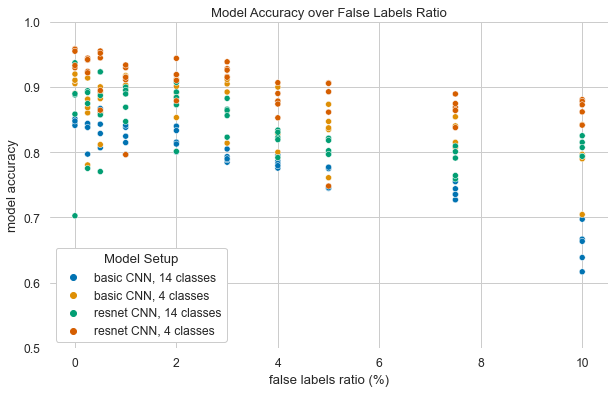

In [48]:
df_hue = df_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_accuracy,
            x='ratio',
            y='accuracy',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model accuracy',
            ylim=(0.5,1),
            title='Model Accuracy over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_accuracy.png', dpi=300, facecolor='white')

In [49]:
df_accuracy_regr = df_accuracy.copy()
df_accuracy_regr.drop(['run', 'epoch', 'metric'], axis=1, inplace=True)
df_accuracy_regr = pd.get_dummies(
    df_accuracy_regr,
    columns=['model', 'classes'],
    drop_first=True
)
df_accuracy_regr.head()

,ratio,accuracy,model_resnet,classes_4
0,0.0,0.844503,0,0
7,0.0,0.844503,0,0
14,0.0,0.851280,0,0
21,0.0,0.841114,0,0
28,0.0,0.847892,0,0


In [50]:
# get independent and dependent variables
X_df = df_accuracy_regr[['accuracy']]
y_df = df_accuracy_regr['ratio']

for column in X_df.columns:
    r, p = pearsonr(X_df[column], y_df)
    print(f'{round(r, 4)} pearsonr, {round(p, 8)} p-value, Variable: {column}')

# split data
X_train, X_test, y_train, y_test = train_test_split(
                                                X_df
                                                , y_df
                                                , test_size=0.15
                                                # , stratify=y_df
                                            )
print(f'\nX_train.shape {X_train.shape}\n\
y_train.shape {y_train.shape}\n\
X_test.shape {X_test.shape}\n\
y_test.shape {y_test.shape}')

-0.4977 pearsonr, 0.0 p-value, Variable: accuracy

X_train.shape (180, 1)
y_train.shape (180,)
X_test.shape (20, 1)
y_test.shape (20,)


In [51]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# reshape data to fit into pipeline
X_train_resh = X_train.values.reshape(-1, 1)
y_train_resh = y_train # .values.reshape(-1, 1)
X_test_resh = X_test.values.reshape(-1, 1)
y_test_resh = y_test # .values.reshape(-1, 1)

print(f'X_train.shape {X_train_resh.shape}\n\
y_train.shape {y_train_resh.shape}\n\
X_test.shape {X_test_resh.shape}\n\
y_test.shape {y_test_resh.shape}')

# initialize estimators and hyperparameter params for each regressor
regr_linear = LinearRegression()
regr_linear_params = {}

regr_lasso = Lasso()
regr_lasso_params = {}
regr_lasso_params['regr__max_iter'] = [10000]
regr_lasso_params['regr__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
regr_lasso_params['regr__warm_start'] = [True, False]
regr_lasso_params['regr__selection'] = ['random', 'cyclic']

regr_elastic = ElasticNet()
regr_elastic_params = {}
regr_elastic_params['regr__max_iter'] = [10000]
regr_elastic_params['regr__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
regr_elastic_params['regr__l1_ratio'] = np.linspace(0.001, 0.999, 20)
regr_elastic_params['regr__warm_start'] = [True, False]
regr_elastic_params['regr__selection'] = ['random', 'cyclic']

regr_ridge = Ridge()
regr_ridge_params = {}
regr_ridge_params['regr__max_iter'] = [10000]
regr_ridge_params['regr__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
regr_ridge_params['regr__solver'] = [
    'auto', 'svd', 'cholesky', 'lsqr'
    , 'sparse_cg', 'sag', 'saga'
]

regr_svr = SVR()
regr_svr_params = {}
regr_svr_params['regr__kernel'] = ['linear', 'poly', 'rbf'] # 'sigmoid'
regr_svr_params['regr__degree'] = [1, 2, 3]
regr_svr_params['regr__gamma'] = [1e-1, 1.0, 10.0]
# regr_svr_params['regr__coef0'] = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
regr_svr_params['regr__C'] = [1e-1, 1.0, 10.0]
# regr_svr_params['regr__epsilon'] = [1e-2, 1e-1, 1.0, 10.0, 100.0]

regr_randomForest = RandomForestRegressor()
regr_randomForest_params = {}
regr_randomForest_params['regr__n_estimators'] = [100, 200, 300, 400, 500]
regr_randomForest_params['regr__criterion'] = ['squared_error'] # 'absolute_error', 'poisson'
regr_randomForest_params['regr__max_depth'] = [1, 2, 3, 4, 5]
regr_randomForest_params['regr__warm_start'] = [True, False]

regr_gradientBoost = GradientBoostingRegressor()
regr_gradientBoost_params = {}
# regr_gradientBoost_params['regr__loss'] = ['squared_error', 'huber']
regr_gradientBoost_params['regr__learning_rate'] = [0.1, 0.3, 0.5, 0.7, 0.9]
regr_gradientBoost_params['regr__n_estimators'] = [100, 200, 300, 400, 500]
# regr_gradientBoost_params['regr__criterion'] = ['friedman_mse', 'squared_error', 'absolute_error']
regr_gradientBoost_params['regr__max_depth'] = [1, 2, 3, 4, 5]
# regr_gradientBoost_params['regr__alpha'] = [0.1, 0.3, 0.5, 0.7, 0.9]
regr_gradientBoost_params['regr__warm_start'] = [True, False]

models_and_params = [
    [regr_linear, regr_linear_params]
    , [regr_lasso, regr_lasso_params]
    , [regr_elastic, regr_elastic_params]
    , [regr_ridge, regr_ridge_params]
    , [regr_svr, regr_svr_params]
    , [regr_randomForest, regr_randomForest_params]
    , [regr_gradientBoost, regr_gradientBoost_params]
]

# initialize logging
log_path = Path('../logs/evauluation_log')
if not os.path.exists(log_path):
    os.mkdir(log_path)

# iterate over models and hyperparameters and train
best_params_per_model = {}
for model, params in models_and_params:
    model_name = f'{str(model)[:-2]}'
    
    # initialize pipeline with regressor and scaler
    pipe = Pipeline(
        steps = [
            # ('scaler', StandardScaler()),
            ('regr', model)
        ]
        # , verbose=True
    )

    # run gridsearch
    print('--------')
    start = time.time()

    gs = GridSearchCV(
        pipe
        , params
        # , n_iter=2
        , n_jobs=-1
        , cv=5
        , scoring='r2'
        , verbose=1
    ).fit(X_train_resh, y_train_resh)

    end = time.time()
    print(f'{model_name} - Training time elapsed: {round((end - start) / 60, 3)} min')

    # add best params + score per model to dict
    best_params_per_model[model_name] = {
        'score': gs.best_score_,
        'best_params': gs.best_params_
    }

# save best params per model
with open(f'{log_path}/best_params_per_model.json', 'w') as f:
    json.dump(best_params_per_model, f)

X_train.shape (180, 1)
y_train.shape (180,)
X_test.shape (20, 1)
y_test.shape (20,)
--------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
LinearRegression - Training time elapsed: 0.051 min
--------
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Lasso - Training time elapsed: 0.021 min
--------
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
ElasticNet - Training time elapsed: 0.034 min
--------
Fitting 5 folds for each of 56 candidates, totalling 280 fits
Ridge - Training time elapsed: 0.005 min
--------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
SVR - Training time elapsed: 0.009 min
--------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomForestRegressor - Training time elapsed: 0.421 min
--------
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
GradientBoostingRegressor - Training time elapsed: 7.576 min


In [52]:
# read models with best params
with open(f'{log_path}/best_params_per_model.json', 'r') as f:
    regression_results = json.load(f)

# print score for each model and get best score / model
best_model = ''
best_train_score = 0

for model, results in regression_results.items():
    score = results["score"]
    print(f'{round(score,6)} - {model}')
    # print(params['best_params'])

    if abs(score) > abs(best_train_score):
        best_train_score = score
        best_model = model
        best_params = results['best_params']
    
print(f'--------\nBest model: {best_model}\n    {round(best_train_score, 5)} - training score')

# transform params for test scoring
best_params_transform = {}
for key, value in best_params.items():
    best_params_transform[key[6:]] = value

# score best model on test set
models = {
    'LinearRegression': regr_linear,
    'Lasso': regr_lasso,
    'ElasticNet': regr_elastic,
    'Ridge': regr_ridge,
    'SVR': regr_svr,
    'RandomForest': regr_randomForest,
    'GradientBoosting': regr_gradientBoost
}

reg = models[best_model].set_params(**best_params_transform)
reg.fit(X_train_resh, y_train_resh)
test_score = reg.score(X_test_resh, y_test_resh)
print(f'    {round(test_score, 5)} - test score')

0.266907 - LinearRegression
0.266996 - Lasso
0.26709 - ElasticNet
0.267117 - Ridge
0.249611 - SVR
0.216734 - RandomForestRegressor
0.194552 - GradientBoostingRegressor
--------
Best model: Ridge
    0.26712 - training score
    0.06925 - test score


------------

#### weighted avg precision plot

In [ ]:
df_precision_w = df.query("metric == 'weighted avg precision'")
print(df_precision_w.shape)
df_precision_w.head()

(200, 7)


,run,model,ratio,classes,epoch,metric,value
4,basic_00000r_14c_20220413-1643,basic,0.0,14,19,weighted avg precision,0.853091
11,basic_00000r_14c_20220413-2345,basic,0.0,14,19,weighted avg precision,0.856458
18,basic_00000r_14c_20220414-1019,basic,0.0,14,19,weighted avg precision,0.871337
25,basic_00000r_14c_20220414-1707,basic,0.0,14,19,weighted avg precision,0.863243
32,basic_00000r_14c_20220415-0056,basic,0.0,14,19,weighted avg precision,0.850647


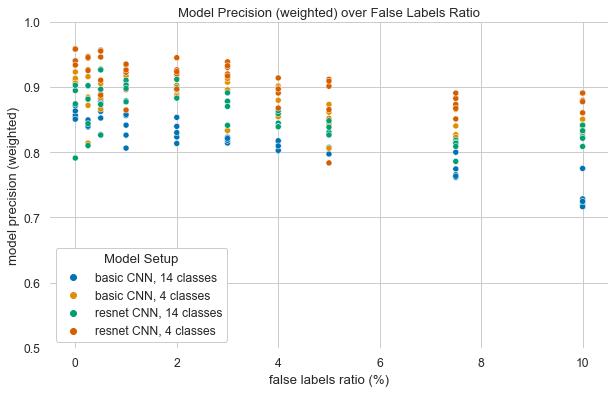

In [ ]:
df_hue = df_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_precision_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model precision (weighted)',
            ylim=(0.5,1),
            title='Model Precision (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_precision.png', dpi=300, facecolor='white')

------------

#### weighted avg recall plot

In [ ]:
df_recall_w = df.query("metric == 'weighted avg recall'")
print(df_recall_w.shape)
df_recall_w.head()

(200, 7)


,run,model,ratio,classes,epoch,metric,value
5,basic_00000r_14c_20220413-1643,basic,0.0,14,19,weighted avg recall,0.844503
12,basic_00000r_14c_20220413-2345,basic,0.0,14,19,weighted avg recall,0.844503
19,basic_00000r_14c_20220414-1019,basic,0.0,14,19,weighted avg recall,0.851280
26,basic_00000r_14c_20220414-1707,basic,0.0,14,19,weighted avg recall,0.841114
33,basic_00000r_14c_20220415-0056,basic,0.0,14,19,weighted avg recall,0.847892


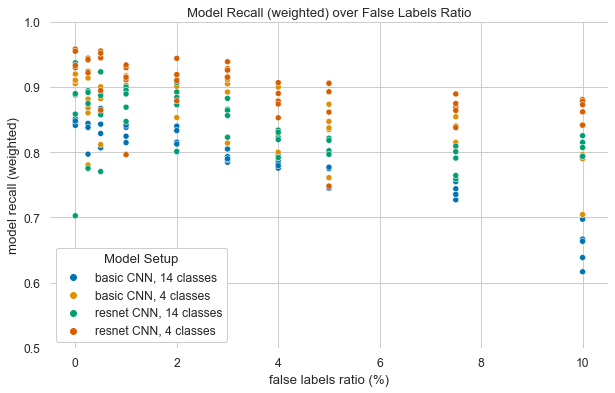

In [ ]:
df_hue = df_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_recall_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model recall (weighted)',
            ylim=(0.5,1),
            title='Model Recall (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_recall.png', dpi=300, facecolor='white')

------------

#### weighted avg f1-score plot

In [ ]:
df_f1score_w = df.query("metric == 'weighted avg f1-score'")
print(df_f1score_w.shape)
df_f1score_w.head()

(200, 7)


,run,model,ratio,classes,epoch,metric,value
6,basic_00000r_14c_20220413-1643,basic,0.0,14,19,weighted avg f1-score,0.845348
13,basic_00000r_14c_20220413-2345,basic,0.0,14,19,weighted avg f1-score,0.842549
20,basic_00000r_14c_20220414-1019,basic,0.0,14,19,weighted avg f1-score,0.854573
27,basic_00000r_14c_20220414-1707,basic,0.0,14,19,weighted avg f1-score,0.844518
34,basic_00000r_14c_20220415-0056,basic,0.0,14,19,weighted avg f1-score,0.844609


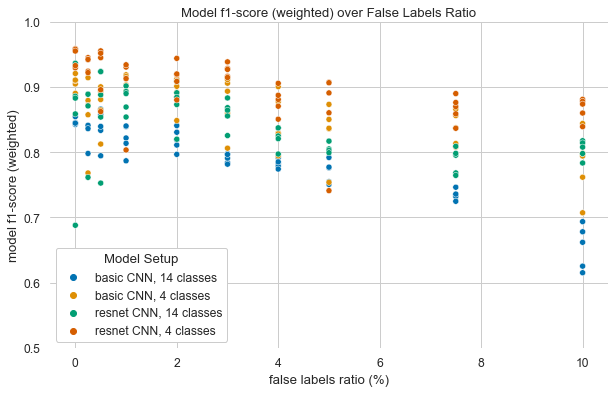

In [ ]:
df_hue = df_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_f1score_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model f1-score (weighted)',
            ylim=(0.5,1),
            title='Model f1-score (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_f1score.png', dpi=300, facecolor='white')

--------------

## aggregated (mean) metric evaluation

In [ ]:
df_aggr = df.query('epoch == 19 & metric==["accuracy", "weighted avg precision", "weighted avg recall", "weighted avg f1-score"]')
df_aggr = df_aggr.groupby(['model', 'classes', 'ratio', 'metric', 'epoch']).mean().reset_index()

df_aggr['delta'] = df_aggr.apply(lambda row:
    row['value'] - df_aggr.query(f'model=="{row.model}" & classes=="{row.classes}" & ratio==0.0 & metric=="{row.metric}"').iloc[0]['value'], axis=1
)

df_aggr

,model,classes,ratio,metric,epoch,value,delta
0,basic,14,0.00,accuracy,19,0.845858,0.000000
1,basic,14,0.00,weighted avg f1-score,19,0.846319,0.000000
2,basic,14,0.00,weighted avg precision,19,0.858955,0.000000
3,basic,14,0.00,weighted avg recall,19,0.845858,0.000000
4,basic,14,0.25,accuracy,19,0.832078,-0.013780
...,...,...,...,...,...,...,...
155,resnet,4,7.50,weighted avg recall,19,0.866943,-0.079819
156,resnet,4,10.00,accuracy,19,0.866943,-0.079819
157,resnet,4,10.00,weighted avg f1-score,19,0.866379,-0.080357
158,resnet,4,10.00,weighted avg precision,19,0.879723,-0.069977


--------------

#### aggr accuracy plot

In [ ]:
df_aggr_accuracy = df_aggr.query("metric == 'accuracy'")
df_aggr_accuracy = df_aggr_accuracy.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()
print(df_aggr_accuracy.shape)
df_aggr_accuracy.head()

(40, 7)


,model,classes,ratio,metric,epoch,value,delta
0,basic,14,0.00,accuracy,19.0,0.845858,0.000000
1,basic,14,0.25,accuracy,19.0,0.832078,-0.013780
2,basic,14,0.50,accuracy,19.0,0.841190,-0.004669
3,basic,14,1.00,accuracy,19.0,0.823117,-0.022741
4,basic,14,2.00,accuracy,19.0,0.820331,-0.025527


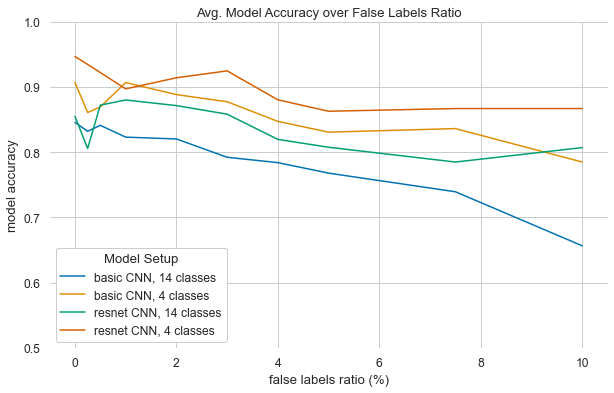

In [ ]:
df_hue = df_aggr_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_accuracy,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model accuracy',
            ylim=(0.5,1),
            title='Avg. Model Accuracy over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_accuracy.png', dpi=300, facecolor='white')

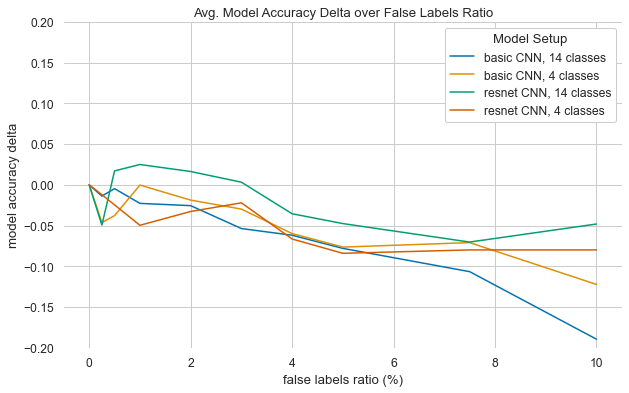

In [ ]:
df_hue = df_aggr_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_accuracy,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model accuracy delta',
            ylim=(-0.2,0.2),
            title='Avg. Model Accuracy Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_accuracy_delta.png', dpi=300, facecolor='white')

------------

#### aggr weighted avg precision plot

In [ ]:
df_aggr_precision_w = df_aggr.query("metric == 'weighted avg precision'")
df_aggr_precision_w = df_aggr_precision_w.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()
print(df_aggr_precision_w.shape)
df_aggr_precision_w.head()

(40, 7)


,model,classes,ratio,metric,epoch,value,delta
0,basic,14,0.00,weighted avg precision,19.0,0.858955,0.000000
1,basic,14,0.25,weighted avg precision,19.0,0.843824,-0.015131
2,basic,14,0.50,weighted avg precision,19.0,0.860047,0.001092
3,basic,14,1.00,weighted avg precision,19.0,0.837603,-0.021352
4,basic,14,2.00,weighted avg precision,19.0,0.832011,-0.026944


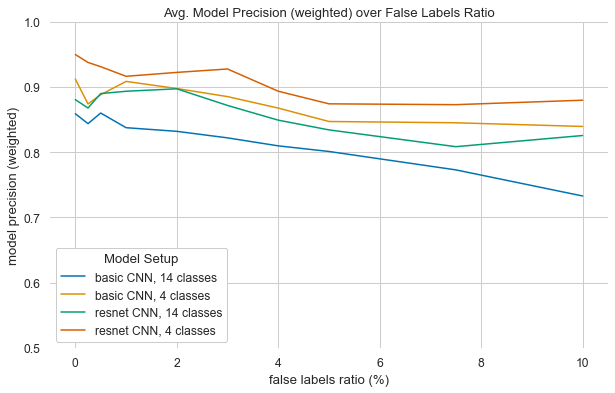

In [ ]:
df_hue = df_aggr_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_precision_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model precision (weighted)',
            ylim=(0.5,1),
            title='Avg. Model Precision (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_precision.png', dpi=300, facecolor='white')

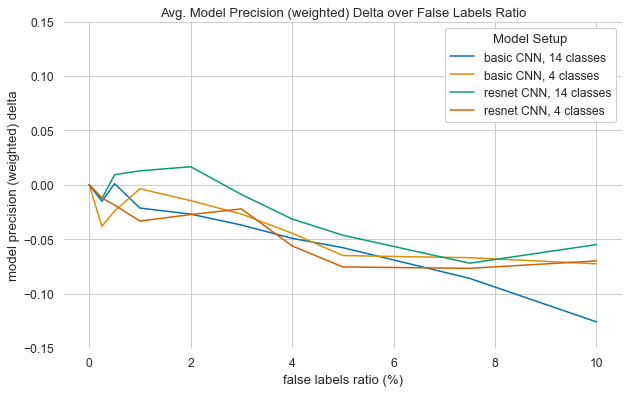

In [ ]:
df_hue = df_aggr_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_precision_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model precision (weighted) delta',
            ylim=(-0.15,0.15),
            title='Avg. Model Precision (weighted) Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_precision_delta.png', dpi=300, facecolor='white')

------------

#### aggr weighted avg recall plot

In [ ]:
df_aggr_recall_w = df_aggr.query("metric == 'weighted avg recall'")
df_recall_w = df_aggr_recall_w.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()
print(df_aggr_recall_w.shape)
df_aggr_recall_w.head()

(40, 7)


,model,classes,ratio,metric,epoch,value,delta
3,basic,14,0.00,weighted avg recall,19,0.845858,0.000000
7,basic,14,0.25,weighted avg recall,19,0.832078,-0.013780
11,basic,14,0.50,weighted avg recall,19,0.841190,-0.004669
15,basic,14,1.00,weighted avg recall,19,0.823117,-0.022741
19,basic,14,2.00,weighted avg recall,19,0.820331,-0.025527


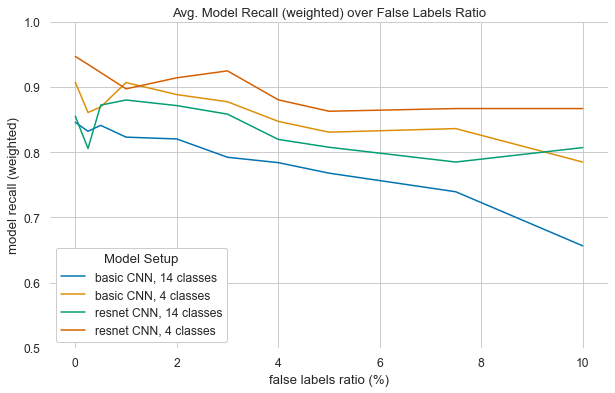

In [ ]:
df_hue = df_aggr_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_recall_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model recall (weighted)',
            ylim=(0.5,1),
            title='Avg. Model Recall (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_recall.png', dpi=300, facecolor='white')

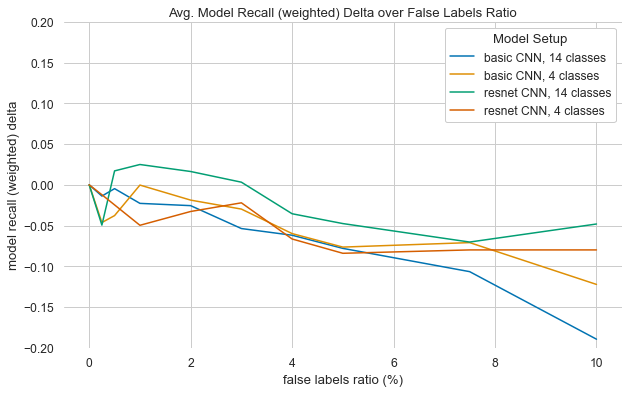

In [ ]:
df_hue = df_aggr_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_recall_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model recall (weighted) delta',
            ylim=(-0.2,0.2),
            title='Avg. Model Recall (weighted) Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_recall_delta.png', dpi=300, facecolor='white')

------------

#### aggr weighted avg f1-score plot

In [ ]:
df_aggr_f1score_w = df_aggr.query("metric == 'weighted avg f1-score'")
df_aggr_f1score_w = df_aggr_f1score_w.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()
print(df_aggr_f1score_w.shape)
df_aggr_f1score_w.head()

(40, 7)


,model,classes,ratio,metric,epoch,value,delta
0,basic,14,0.00,weighted avg f1-score,19.0,0.846319,0.000000
1,basic,14,0.25,weighted avg f1-score,19.0,0.831295,-0.015024
2,basic,14,0.50,weighted avg f1-score,19.0,0.838249,-0.008070
3,basic,14,1.00,weighted avg f1-score,19.0,0.820368,-0.025951
4,basic,14,2.00,weighted avg f1-score,19.0,0.819614,-0.026705


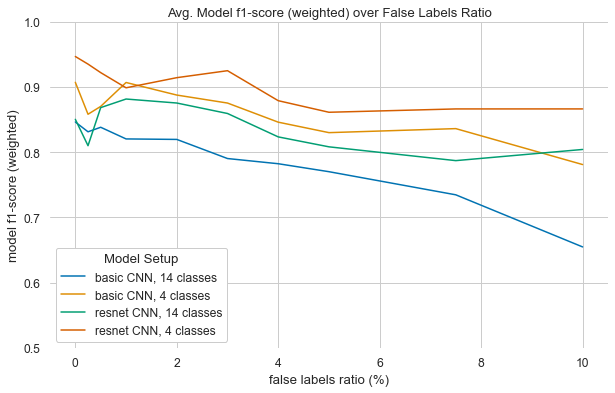

In [ ]:
df_hue = df_aggr_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_f1score_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model f1-score (weighted)',
            ylim=(0.5,1),
            title='Avg. Model f1-score (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_f1score.png', dpi=300, facecolor='white')

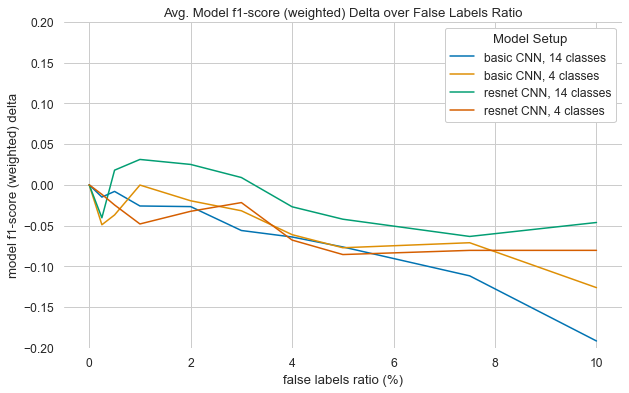

In [ ]:
df_hue = df_aggr_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_f1score_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model f1-score (weighted) delta',
            ylim=(-0.2,0.2),
            title='Avg. Model f1-score (weighted) Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_f1score_delta.png', dpi=300, facecolor='white')